In [1]:
## Install TigerGraph it is not already installed
#!pip install pyTigerGraph

## Connect to TigerGraph Server
Change hostname, username and password below

In [6]:
import pyTigerGraph as tg
import json

hostName = "https://dataprivacy2022.i.tgcloud.io"
userName = "tigergraph"
password = ""

conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password, version="3.5.0")
print(conn)

In [8]:
# Test connection using GSQL ls command
print(conn.gsql('ls', options=[]))

---- Global vertices, edges, and all graphs
Vertex Types:
Edge Types:

Graphs:
Jobs:


JSON API version: v2
Syntax version: v2



### Clear graph if needed
#### CAUTION - IT WILL DELETE ALL DATA

In [9]:
#print(conn.gsql('drop all', options=[]))

# Create Schema

Schema design diagram

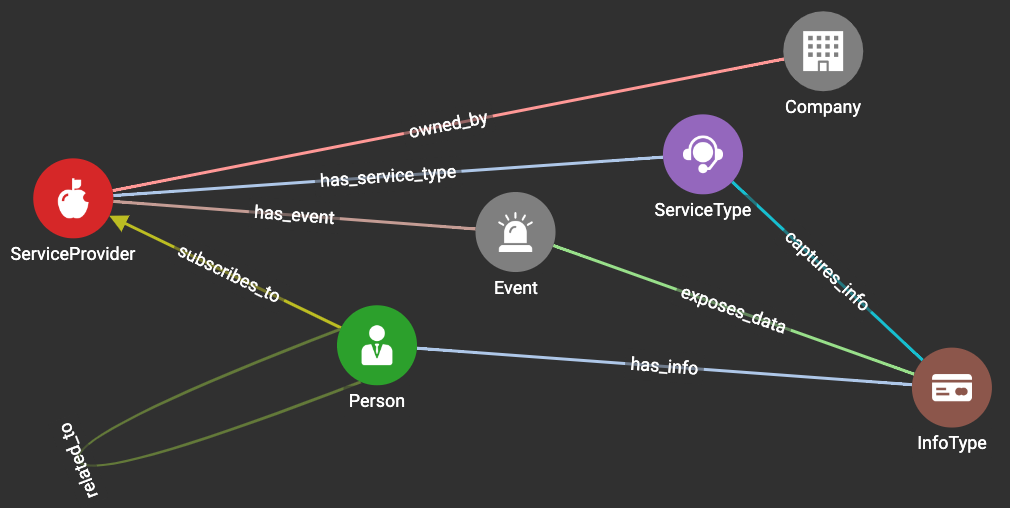


## Create Vertices and Edges



In [10]:
conn.gsql('''
CREATE VERTEX Person(PRIMARY_ID name STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
CREATE VERTEX ServiceProvider(PRIMARY_ID name STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
CREATE VERTEX ServiceType(PRIMARY_ID name STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
CREATE VERTEX InfoType(PRIMARY_ID name STRING, category STRING, value STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
CREATE VERTEX Event(PRIMARY_ID event STRING, eventYear INT, eventType STRING, url STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
CREATE VERTEX Company(PRIMARY_ID id INT) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
''')

'Successfully created vertex types: [Person].\nSuccessfully created vertex types: [ServiceProvider].\nSuccessfully created vertex types: [ServiceType].\nSuccessfully created vertex types: [InfoType].\nSuccessfully created vertex types: [Event].\nSuccessfully created vertex types: [Company].'

In [11]:
conn.gsql('''
CREATE DIRECTED EDGE subscribes_to(FROM Person, TO ServiceProvider) WITH REVERSE_EDGE="reverse_info_shared"
CREATE UNDIRECTED EDGE captures_info(FROM ServiceType, TO InfoType)
CREATE UNDIRECTED EDGE has_info(FROM Person, TO InfoType)
CREATE UNDIRECTED EDGE has_service_type(FROM ServiceProvider, TO ServiceType)
CREATE UNDIRECTED EDGE has_event(FROM ServiceProvider, TO Event)
CREATE UNDIRECTED EDGE exposes_data(FROM Event, TO InfoType)
CREATE UNDIRECTED EDGE owned_by(FROM ServiceProvider, TO Company)
CREATE UNDIRECTED EDGE related_to(FROM Person, TO Person)
''')

'Successfully created edge types: [subscribes_to].\nSuccessfully created reverse edge types: [reverse_info_shared].\nSuccessfully created edge types: [captures_info].\nSuccessfully created edge types: [has_info].\nSuccessfully created edge types: [has_service_type].\nSuccessfully created edge types: [has_event].\nSuccessfully created edge types: [exposes_data].\nSuccessfully created edge types: [owned_by].\nSuccessfully created edge types: [related_to].'

## Create Graph

In [12]:
conn.gsql('''
    CREATE GRAPH PKG(*)
''')

'Stopping GPE GSE RESTPP\nSuccessfully stopped GPE GSE RESTPP in 24.155 seconds\nStarting GPE GSE RESTPP\nSuccessfully started GPE GSE RESTPP in 0.262 seconds\nThe graph PKG is created.'

# Connect to Graph and update connection object with Token

In [13]:
graphName = "PKG"
conn.graphname = graphName
secret = conn.createSecret()
token = conn.getToken(secret, setToken=True)[0]
print("token:'"+token+"''")
print("secret:'"+secret+"''")

# connect to graph with token
conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password, graphname=graphName, apiToken=token)

token:'pkbvv7p1vombha22pj4uilp98fj10mtd''
secret:'3l214s9iflhu3m3oq8tfc1b8p53a4jcp''


In [15]:
## CREATE A VERTEX OBJECT

# results = conn.gsql(
# '''
# USE GRAPH PKG
# INTERPRET QUERY () {

#   // add a celebrity person node using INSERT INTO statement.
#   INSERT INTO Person VALUES (1,"Tiger" );}
# ''')
# results

# # Sample result
# #'Using graph \'PKG\'\n{\n"error": false,\n"message": "",\n"version": {\n"schema": 0,\n"edition": "enterprise",\n"api": "v2"\n},\n"results": []\n}'

# Load Data

## Create Loading Jobs

### Load services

In [16]:
# Load ServiceProvider and ServiceType
results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_job_service FOR GRAPH PKG {
      DEFINE FILENAME MyDataSource;
      LOAD MyDataSource TO EDGE has_service_type VALUES($0 ServiceProvider, $1 ServiceType) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
      LOAD MyDataSource TO EDGE owned_by VALUES($0 ServiceProvider, $2 Company) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
 }
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_job_service].


In [17]:
filename = "./data/service.csv"
res = conn.uploadFile(filename, fileTag='MyDataSource', jobName='load_job_service', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 20,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [],
      "edge": [
        {
          "typeName": "has_service_type",
          "validObject": 20,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        },
        {
          "typeName": "owned_by",
          "validObject": 20,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 20,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


### Load events

In [18]:
# Load Events

results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_job_event FOR GRAPH PKG {
      DEFINE FILENAME EventsData;
      LOAD EventsData TO VERTEX Event VALUES($1, $2, $3, $4) USING header="TRUE", separator=",", EOL="\n", QUOTE="double";
      LOAD EventsData TO EDGE has_event VALUES($0 ServiceProvider, $1 Event) USING header="TRUE", separator=",", EOL="\n", QUOTE="double";
    }
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_job_event].


In [19]:
filename = "./data/event.csv"
res = conn.uploadFile(filename, fileTag='EventsData', jobName='load_job_event', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 5,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [
        {
          "typeName": "Event",
          "validObject": 5,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "edge": [
        {
          "typeName": "has_event",
          "validObject": 5,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


### Load info type and captures_info

In [20]:
results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_job_info_type FOR GRAPH PKG {
      DEFINE FILENAME MyDataSource;
      LOAD MyDataSource TO VERTEX InfoType VALUES($1, $2, $3) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
      LOAD MyDataSource TO EDGE captures_info VALUES($0 ServiceType, $1 InfoType) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
    }
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_job_info_type].


In [21]:

filename = "./data/service_info.csv"
res = conn.uploadFile(filename, fileTag='MyDataSource', jobName='load_job_info_type', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 38,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [
        {
          "typeName": "InfoType",
          "validObject": 38,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "edge": [
        {
          "typeName": "captures_info",
          "validObject": 38,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


### Load Events and exposed data

In [22]:
# Load Events
results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_event_exposure FOR GRAPH PKG {
        DEFINE FILENAME MyDataSource;
        LOAD MyDataSource TO EDGE exposes_data VALUES($0 Event, $1 InfoType) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
    }
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_event_exposure].


In [23]:

filename = "./data/exposes_data.csv"
res = conn.uploadFile(filename, fileTag='MyDataSource', jobName='load_event_exposure', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 14,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [],
      "edge": [
        {
          "typeName": "exposes_data",
          "validObject": 14,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


### Load Person

In [24]:
# Load Events
results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_person FOR GRAPH PKG {
      DEFINE FILENAME MyDataSource;
        LOAD MyDataSource TO EDGE subscribes_to VALUES($0 Person, $1 ServiceProvider) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
}
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_person].


In [25]:

filename = "./data/person.csv"
res = conn.uploadFile(filename, fileTag='MyDataSource', jobName='load_person', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 11,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [],
      "edge": [
        {
          "typeName": "subscribes_to",
          "validObject": 11,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


### Load Relation

In [26]:
# Load Events
results = conn.gsql('''
USE GRAPH PKG
BEGIN
CREATE LOADING JOB load_relation FOR GRAPH PKG {
      DEFINE FILENAME MyDataSource;
        LOAD MyDataSource TO EDGE related_to VALUES($0 Person, $1 Person) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";

}
END
''')

print(results)

Using graph 'PKG'
Successfully created loading jobs: [load_relation].


In [27]:

filename = "./data/relation.csv"
res = conn.uploadFile(filename, fileTag='MyDataSource', jobName='load_relation', sep=",")
print(json.dumps(res, indent=2))

[
  {
    "sourceFileName": "Online_POST",
    "statistics": {
      "validLine": 2,
      "rejectLine": 0,
      "failedConditionLine": 0,
      "notEnoughToken": 1,
      "invalidJson": 0,
      "oversizeToken": 0,
      "vertex": [],
      "edge": [
        {
          "typeName": "related_to",
          "validObject": 2,
          "noIdFound": 0,
          "invalidAttribute": 0,
          "invalidVertexType": 0,
          "invalidPrimaryId": 0,
          "invalidSecondaryId": 0,
          "incorrectFixedBinaryLength": 0
        }
      ],
      "deleteVertex": [],
      "deleteEdge": []
    }
  }
]


## Queries

### Get list of all services by Service Type

In [28]:
conn.gsql('''
CREATE QUERY get_service_providers_by_type() FOR GRAPH PKG SYNTAX v2{ 
  
  start = {ServiceType.*};
  
  SetAccum<VERTEX> @connected_vertex;
  
  providers_by_type = SELECT s FROM start:s - (has_service_type) - ServiceProvider:p
    ACCUM
      s.@connected_vertex += p;

  PRINT providers_by_type [providers_by_type.@connected_vertex as providers];
  
}
''')

'Successfully created queries: [get_service_providers_by_type].'

In [29]:
conn.gsql('INSTALL QUERY get_service_providers_by_type')

'Start installing queries, about 1 minute ...\nget_service_providers_by_type query: curl -X GET \'https://127.0.0.1:9000/query/PKG/get_service_providers_by_type\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\nQuery installation finished.'

### Get service providers by user

In [30]:
conn.gsql('''
CREATE QUERY get_service_providers_by_user(vertex<Person> input_user) FOR GRAPH PKG SYNTAX v2{ 
  
  start = {input_user};
  
  SetAccum<VERTEX> @connectedVerties;
  
  serviceProviders = 
    SELECT sp 
    FROM start:p - (subscribes_to>) - ServiceProvider:sp
    ACCUM p.@connectedVerties+=sp;
  
  serviceType = 
    select st 
    FROM serviceProviders:sp - (has_service_type) - ServiceType:st
    ACCUM sp.@connectedVerties+=st ;

  PRINT start ;
  PRINT serviceProviders as subscribes_to;
}
''')

'Successfully created queries: [get_service_providers_by_user].'

In [31]:
conn.gsql('INSTALL QUERY get_service_providers_by_user')

'Start installing queries, about 1 minute ...\nget_service_providers_by_user query: curl -X GET \'https://127.0.0.1:9000/query/PKG/get_service_providers_by_user?input_user=VALUE\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\nQuery installation finished.'

### Query - get list of all events for input user and related users with type of information

In [32]:
conn.gsql(
'''
    CREATE QUERY get_events_with_user(vertex<Person> input_user) FOR GRAPH PKG SYNTAX v2{
  

  SetAccum<VERTEX> @connected_vertex;
  SetAccum<VERTEX> @person;
  ListAccum<STRING> @infoValue;
  
  
  
  start = {input_user};
  
  base_events = 
    SELECT e 
    FROM start:p - (subscribes_to>) - ServiceProvider:sp - (has_event) - Event:e - (exposes_data) - InfoType:i
  
  ACCUM e.@connected_vertex += i, e.@person+=p, e.@infoValue += i.value;
  
  related_persons = 
    SELECT rp
    FROM start:p - (related_to) - Person:rp;
  
  related_events = 
    SELECT e 
    FROM related_persons:rp - (subscribes_to>) - ServiceProvider:sp - (has_event) - Event:e - (exposes_data) - InfoType:i
  ACCUM e.@connected_vertex += i, e.@person+=rp, e.@infoValue += i.value;

  PRINT base_events, related_events;
    }
'''
)

'Successfully created queries: [get_events_with_user].'

In [33]:
conn.gsql('INSTALL QUERY get_events_with_user')

'Start installing queries, about 1 minute ...\nget_events_with_user query: curl -X GET \'https://127.0.0.1:9000/query/PKG/get_events_with_user?input_user=VALUE\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\nQuery installation finished.'

### Running queries

In [158]:
import pyTigerGraph as tg
import json

hostName = "https://dataprivacy2022.i.tgcloud.io"
userName = "tigergraph"
password = ""

conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password, version="3.5.0")

graphName = "PKG"
conn.graphname = graphName
secret = conn.createSecret()
token = conn.getToken(secret, setToken=True)[0]
# print("token:'"+token+"''")
# print("secret:'"+secret+"''")

# connect to graph with token
conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password, graphname=graphName, apiToken=token)

### Show all security events for a person and his/her related persons

#### Legend, persons - blue, event -red, data exposed - yellow

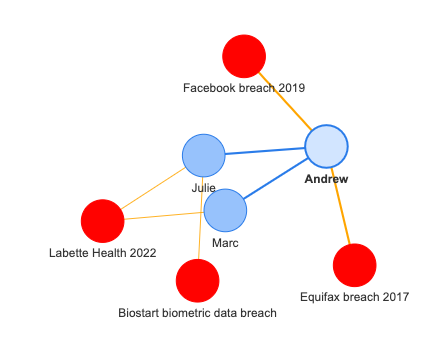

In [156]:
# Import for creating visual output
from pyvis.network import Network
from IPython.display import IFrame

G = Network(notebook=True)

# provide input user
params_input_user = "Andrew"

# run query
res = conn.runInstalledQuery('get_events_with_user', {"input_user": params_input_user})

# format output
events_for_input_person = res[0]['base_events']
events_for_related_person = res[0]['related_events']

related_persons = [ x['attributes']['@person'] for x in events_for_related_person]
e1 = [ x["v_id"] for x in events_for_input_person]
e2 = [ x["v_id"] for x in events_for_related_person]


# print output
print("Security events related to %s - %s" %(params_input_user, e1))
print("Users related to %s - %s" %(params_input_user, related_persons))
print("Security events related to related persons - %s" %(e2))

# Create graph

# Add input_user  and related events
G.add_node(params_input_user)
for e in events_for_input_person:
    if e['attributes']['eventType'] == 'Data leakage':
        G.add_node(e['v_id'], color='red')
        G.add_edge(params_input_user,e['v_id'], color='orange')
        

# Add realted_persons and their related events
for x in events_for_related_person:
    # add events tp graph
    if x['attributes']['eventType'] == 'Data leakage':
        G.add_node(x['v_id'], color='red')
    # add related perons
    for y in x['attributes']['@person']:
        G.add_node(y)
        G.add_edge(params_input_user,y)
        G.add_edge(x['v_id'],y, color='orange')

G.show('events_by_user.html')
# IFrame('events_by_user.html', width=800, height=400)


Security events related to Andrew - ['Equifax breach 2017', 'Facebook breach 2019']
Users related to Andrew - [['Marc', 'Julie'], ['Julie']]
Security events related to related persons - ['Labette Health 2022', 'Biostart biometric data breach']


### Show all security events for a person and his/her related persons with type of data exposed

#### Legend, persons - blue, event -red, data exposed - yellow

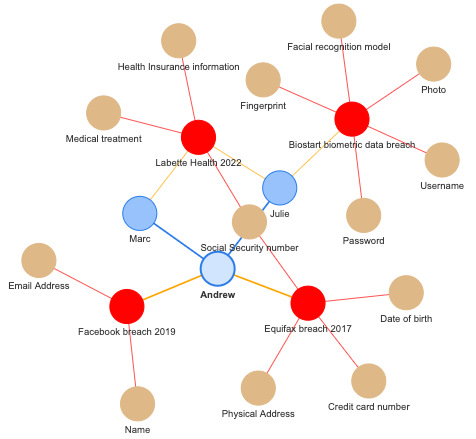

In [157]:
# Import for creating visual output
from pyvis.network import Network
G = Network(notebook=True)

# provide input user
params_input_user = "Andrew"

# run query
res = conn.runInstalledQuery('get_events_with_user', {"input_user": params_input_user})

# format output
events_for_input_person = res[0]['base_events']
events_for_related_person = res[0]['related_events']

related_persons = [ x['attributes']['@person'] for x in events_for_related_person]
e1 = [ x["v_id"] for x in events_for_input_person]
e2 = [ x["v_id"] for x in events_for_related_person]


# print output
print("Security events related to %s - %s" %(params_input_user, e1))
print("Users related to %s - %s" %(params_input_user, related_persons))
print("Security events related to related persons - %s" %(e2))

# Create graph

# Add input_user  and related events
G.add_node(params_input_user)
for e in events_for_input_person:
    if e['attributes']['eventType'] == 'Data leakage':
        G.add_node(e['v_id'], color='red')
        G.add_edge(params_input_user,e['v_id'], color='orange')
        for d in e['attributes']['@connected_vertex']:
            G.add_node(d, color='BurlyWood')
            G.add_edge(d,e['v_id'], color='red')
        

# Add realted_persons and their related events
for x in events_for_related_person:
    # add events tp graph
    if x['attributes']['eventType'] == 'Data leakage':
        G.add_node(x['v_id'], color='red')
    # add related perons
    for y in x['attributes']['@person']:
        G.add_node(y)
        G.add_edge(params_input_user,y)
        G.add_edge(x['v_id'],y, color='orange')
        
    print(x['attributes']['@connected_vertex'])
    if type(x['attributes']['@connected_vertex']) == list:
        for d in x['attributes']['@connected_vertex']:
            G.add_node(d, color='BurlyWood')
            G.add_edge(d,x['v_id'], color='red')
    else:
        G.add_node(x['attributes']['@connected_vertex'], color='brown')
        G.add_edge(x['attributes']['@connected_vertex'],x['v_id'], color='red')

G.show('events_by_user_with_data.html')
# IFrame('events_by_user_with_data.html', width=800, height=600)


Security events related to Andrew - ['Equifax breach 2017', 'Facebook breach 2019']
Users related to Andrew - [['Marc', 'Julie'], ['Julie']]
Security events related to related persons - ['Labette Health 2022', 'Biostart biometric data breach']
['Medical treatment', 'Health Insurance information', 'Social Security number']
['Password', 'Username', 'Fingerprint', 'Facial recognition model', 'Photo']


### Show more details of the event, like what data was breached and URL that user can refer to

In [177]:
pd.concat([pd.json_normalize(res[0]['base_events']),pd.json_normalize(res[0]['related_events'])])

,v_id,v_type,attributes.event,attributes.eventYear,attributes.eventType,attributes.url,attributes.@person,attributes.@connected_vertex,attributes.@infoValue
0,Equifax breach 2017,Event,Equifax breach 2017,2017,Data leakage,https://en.wikipedia.org/wiki/2017_Equifax_dat...,[Andrew],"[Date of birth, Credit card number, Physical A...","[High, High, , High]"
1,Facebook breach 2019,Event,Facebook breach 2019,2019,Data leakage,https://www.theguardian.com/technology/2018/se...,[Andrew],"[Name, Email Address]","[High, High]"
0,Labette Health 2022,Event,Labette Health 2022,2022,Data leakage,https://www.labettehealth.com/about-us/labette...,"[Marc, Julie]","[Medical treatment, Health Insurance informati...","[, , , , , ]"
1,Biostart biometric data breach,Event,Biostart biometric data breach,2019,Data leakage,https://us.norton.com/internetsecurity-emergin...,[Julie],"[Password, Username, Fingerprint, Facial recog...","[, , High, , Medium]"


### List service types that users generally subscribe to and show common service providers 

In [189]:
sp_types = conn.runInstalledQuery('get_service_providers_by_type')
frame = []
for i in sp_types[0]['providers_by_type']:
    frame.append(pd.json_normalize(i))
pd.concat(frame)

,v_id,v_type,attributes.providers
0,Insurance provider,ServiceType,[We insure]
0,Security servcies,ServiceType,[Biostar2]
0,Chat platform,ServiceType,[Whatsapp]
0,Payment service,ServiceType,[Google Pay]
0,Search Engine,ServiceType,[Google]
0,Other Financial services,ServiceType,[Equifax]
0,Social media,ServiceType,"[Instagram, Facebook]"
0,Maps,ServiceType,[Google Maps]
0,Hospital,ServiceType,[Global healthcare]
0,Bank,ServiceType,[Citibank]


.

### Find which companies ultimately own the data 

remember there is relation ship between companies and servic provider

example - Goolgle > Google Maps > Maps Service > Geo location

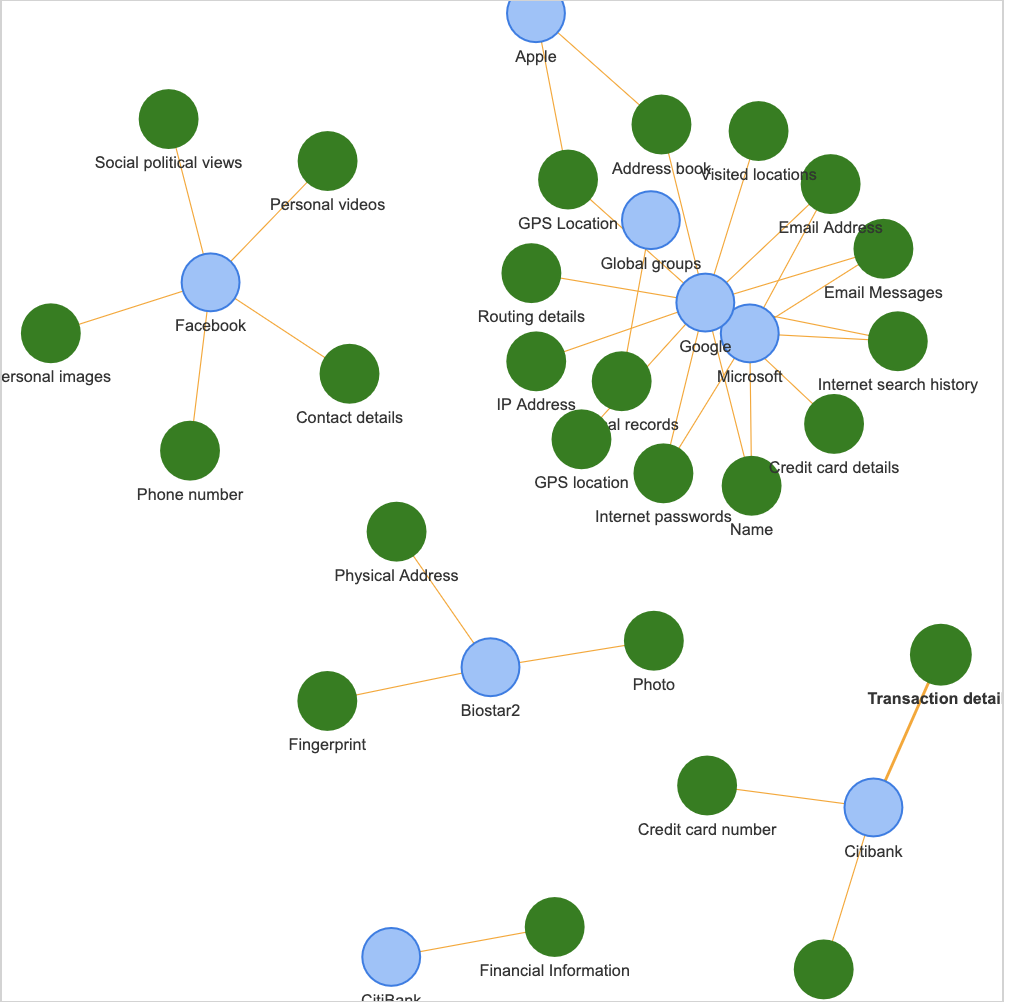

In [194]:
r = conn.runInterpretedQuery(
'''
  INTERPRET QUERY get_companies_by_data_collected() FOR GRAPH PKG SYNTAX v2{
  
  SetAccum<VERTEX> @data_type;
  
  start = {Company.*};
  
  result = 
    SELECT c 
    FROM start:c - () - ServiceProvider:sp - () - ServiceType:st - () - InfoType:i
    ACCUM c.@data_type += i;

  PRINT result;
    }
'''
)
r

[{'result': [{'v_id': 'Microsoft', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Internet passwords', 'Internet search history', 'Name', 'Email Messages', 'Email Address']}}, {'v_id': 'Facebook', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Contact details', 'Phone number', 'Personal videos', 'Personal images', 'Social political views']}}, {'v_id': 'Citibank', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Transaction details', 'Credit score', 'Credit card number']}}, {'v_id': 'Global groups', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Medical records']}}, {'v_id': 'CitiBank', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Financial Information']}}, {'v_id': 'Apple', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Address book', 'GPS Location']}}, {'v_id': 'Biostar2', 'v_type': 'Company', 'attributes': {'id': 0, '@data_type': ['Fingerprint', 'Physical Address', 'Photo']}}, {'v_id': 'Google', 'v_ty

In [204]:
CG = Network(notebook=True)

# Create graph

# Add input_user  and related events

for c in r[0]['result']:
    CG.add_node(c['v_id'])
    for d in c['attributes']['@data_type']:
        CG.add_node(d, color='green')
        CG.add_edge(c['v_id'],d, color='orange')
        
CG.show('companies_collect_data.html')

IFrame('companies_collect_data.html', width=800, height=600)
